## Information on **Bounded trajectory regression** :

file : analyse/05_08_bounds/analyse_08_may.ipynb

This experiment is the main topic of my project. Given a maximal perturbation radius, we show that each coordinate of a predicted trajectory can be bounded. The theory behind this experiment is explained in the main readme.md. 

### Basic bounded regression

First, the idea was to exactly implement the formulas. To implement (1), a monte carlo was used, with N=100 resampling of the noise, and with the function f being the s-lstm with d-pool module. To approximate the expectation, the mean over all the noisy samples is taken, coordinate-wise<br>
During the whole project, we only added noise on the last 3 timesteps of the observation trajectories. As the formulla (1) expects noise on the whole input, we have a more constrained aproach, and thus we could hope for tighter bounds with modifications to the formulla.

The bounds u and l are supposed to be absolute (i.e. no output of the s-lstm could go beyond). As trajectory prediction is a regression problem, no such bounds can exist. We decided to fix the same bounds for all coordinates of a scene. To choose their value, we would first generate the N predictions with the s-lstm, look at the 4 most extreme coordinates ($x_l, x_u, y_l, y_u$), and add a margin to each of them. This way, the bounds chosen should hold for the vast majority of any prediction, given a small perturbation on the observation.
<p align="center">
    <img src="../../figures_readme/mean_smoothing_formulla.png"  width="800">
</p>

### Other expectations

Secondly, we wanted to experiment with other "expectation" functions. Instead of using the mean in the monte carlo resampling, we tried two types of medians. Although this would change the implication of the formula, we wanted to see if the bounds were tighter.<br>
The median type 1 is the trajectory that has to smallest distance to all the other sampled trajectories. A benefit of median type 1 is that it is an existing trajectory, whereas mean or median type 2 are "crafted" trajectories not purely generated by the s-lstm model.<br>
The median type 2 is alike the mean, we just take the median of each coordinate separately.

### Diffusion bounded regression

Thirdly, I added diffusion noising and denoising to the pipeline. The diffusion denoiser has for goal to remove a part of the noise added and making the trajectory "more plausible". Then, the expectation is again approximated with the mean. <br>
The theory holds in this case because we can rewrite   $\mathop{\mathbb{E}}[f\circ h_{denoise}(x+\epsilon)] = \mathop{\mathbb{E}}[f'(x+\epsilon)]$. As the noise has to be added through the diffusion process, a correspondence with $\sigma$ must be established. This part is explained in the main readme.

The model used is trained to **generate** predictions given observations, but we want to **denoise** observations given noisy observations. To do so, we trick the model by giving it only a part of the observations (6 first timesteps) and asking it to generate the last 3 timesteps as predictions (which are in fact still observations). Moreover, as we want to denoise and not generate from pur noise, we give the model 3 last noisy observation and make it continue the denoising process from time $t^*$, as explained in the main readme.

### Metrics and disclamer

In the experiment, the parameter $r$ corresponds to the maximal $L_2$ norm of the perturbation $\delta$. The number reported, for each scene are: ade (average displacement error), fde (final displacement error), abd (average box dimension), and fbd (final box dimension). The fbd/abd are metrics designed to evaluate how tight the bounds on each coordinate are. In the explample below, $fde = \frac{w_3 + h_3}{2}$ and $ade = \frac{\sum_{i=1}^3 w_i + h_i}{2*3}$, averaged across all agents.
<p align="center">
    <img src="../../figures_readme/abd_fbd.png"  width="600">
</p>

A danger of using mean, mean with diffusion, or median type 2, is that the trajectory resulting from the expectation is not "real". In the case of an unfortunate multimodality, the "mean" trajectory could not be feasible. This was not investigated further.

The diffusion model I used is denoising on the **velocity** and not on the position. As it has to derivate and integrate the positions to denoise, one may lose precision due to numerical aproximations.

Complementary informations are given under each section below, and the plots are explained.

### Code : 

To generate those data, the files *bounded_regression\bound_predictor.py* and *bounded_regression\bound_model.py* were used. To run the code, a bash script named *run_bounds_smoothing.bat* can be launched (on Windows). In this file the flag --function can be chosen between "mean", "median1", "median2" and "diffusion" to change the function used to "summarize" the random noisy trajectories.

For the diffusion part, the file *diffusion_bound_regression/MID_from_git/denoise_test.py* contains the object declaration. This file imports many other existing objects from the MID diffusion package.

To train the diffusion model, the file *diffusion_bound_regression/MID_from_git/main.py* is called, and it uses the whole library in *diffusion_bound_regression/MID_from_git*. The .bat script *run_diff_training.bat* is provided to begin the training. <br>
Two .yaml file, *diffusion_bound_regression\MID_from_git\configs\my_config.yaml* and *diffusion_bound_regression\MID_from_git\configs\my_config_eval.yaml*, contains the parameters. One must specify at which epochs one wants to save a checkpoint of the model (*eval_every*), and the model from which epoch one wants to use for testing (*eval_at*). The trained model is automatically saved in the *diffusion_bound_regression\MID_from_git\experiments\my_config* folder and must be moved into the *diffusion_bound_regression\MID_from_git\experiments\my_config_eval* folder.

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# with mean

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [130]:
df_r_001_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01_mean = pd.read_csv("data/mean/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/mean/temp_sig0.5_r0.1.txt", sep="\t")

df_all_mean = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01_mean, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [131]:
df_mean_mean = df_all_mean.groupby(["r", "sigma"], as_index=False).mean()

In [132]:
df_mean_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.561490,1.196024,2.283751,2.117378
1,0.01,0.10,710.017165,0.594069,1.246066,1.172176,1.090146
2,0.01,0.50,710.017165,0.839427,1.620344,0.274974,0.260446
3,0.05,0.05,710.017165,0.561329,1.194686,10.140477,9.580723
4,0.05,0.10,710.017165,0.593372,1.244276,5.686684,5.315468
5,0.05,0.50,710.017165,0.841076,1.622002,1.375492,1.303030
6,0.10,0.05,710.017165,0.560539,1.194769,14.988954,14.667803
7,0.10,0.10,710.017165,0.594628,1.246115,10.363546,9.819495
8,0.10,0.50,710.017165,0.845402,1.628395,2.737443,2.594348


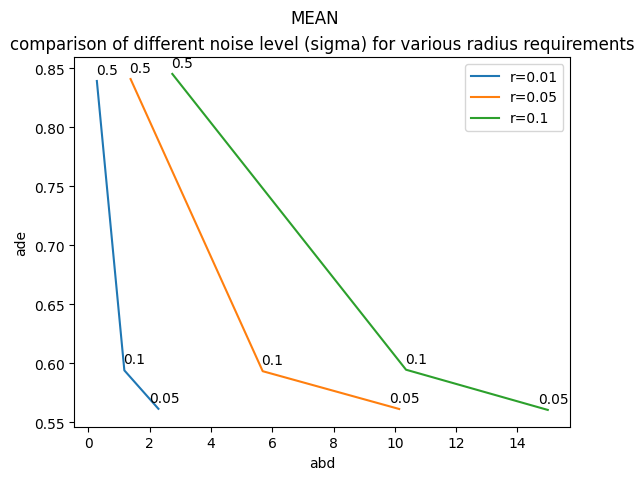

In [133]:
fig, ax = plt.subplots()
df_mean_mean
[ax.plot(df_mean_mean[df_mean_mean["r"] == r]["abd"], df_mean_mean[df_mean_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.legend()
plt.suptitle("MEAN")

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_mean_mean[df_mean_mean["r"] == r]["abd"],df_mean_mean[df_mean_mean["r"] == r]["ade"])):

        label = str(df_mean_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(15,5), # distance from text to points (x,y)
                    ha='right')

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The mean was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the ade gets worse. <br>
Also, for values of $\sigma \lessapprox 10*r$, we see that the box dimensions gets really large.

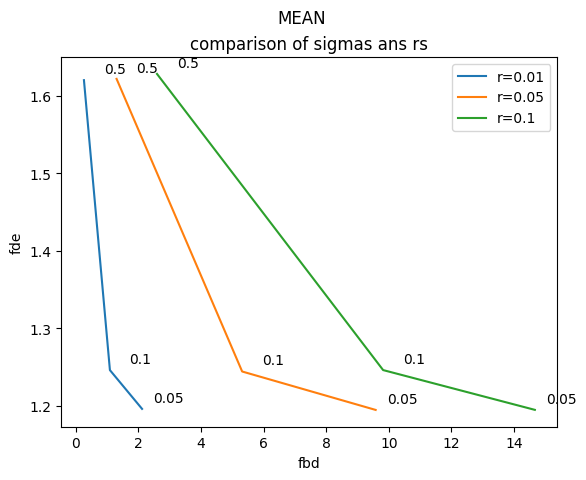

In [134]:
fig, ax = plt.subplots()
[ax.plot(df_mean_mean[df_mean_mean["r"] == r]["fbd"], df_mean_mean[df_mean_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of sigmas ans rs", xlabel="fbd", ylabel="fde")
plt.legend()
plt.suptitle("MEAN")

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_mean_mean[df_mean_mean["r"] == r]["fbd"],df_mean_mean[df_mean_mean["r"] == r]["fde"])):

        label = str(df_mean_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

# with median 1

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [135]:
df_r_001_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/med1/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/med1/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/med1/temp_sig0.5_r0.1.txt", sep="\t")

df_all_med1 = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [136]:
df_med1_mean = df_all_med1.groupby(["r", "sigma"], as_index=False).mean()

In [137]:
df_med1_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.568305,1.198737,2.283699,2.117184
1,0.01,0.10,710.017165,0.605967,1.252051,1.172167,1.090048
2,0.01,0.50,710.017165,0.880531,1.590744,0.274961,0.260382
3,0.05,0.05,710.017165,0.567788,1.196975,10.140213,9.580026
4,0.05,0.10,710.017165,0.606395,1.251170,5.686633,5.314972
5,0.05,0.50,710.017165,0.888437,1.597930,1.375432,1.302711
6,0.10,0.05,710.017165,0.568541,1.199886,14.988898,14.667498
7,0.10,0.10,710.017165,0.607478,1.251299,10.363377,9.818592
8,0.10,0.50,710.017165,0.887665,1.593811,2.737342,2.593831


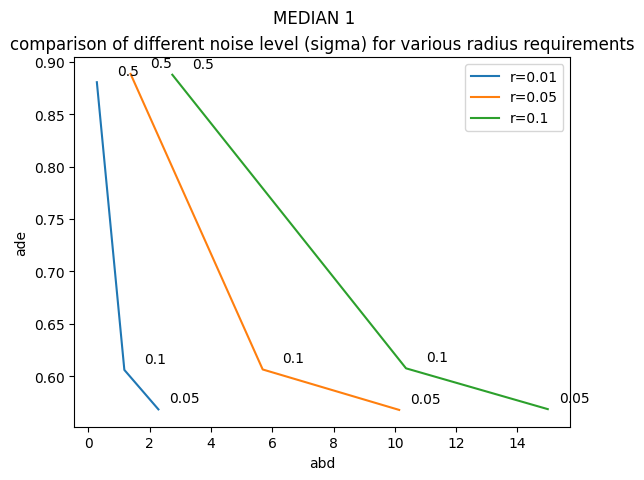

In [138]:
fig, ax = plt.subplots()

[ax.plot(df_med1_mean[df_med1_mean["r"] == r]["abd"], df_med1_mean[df_med1_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("MEDIAN 1")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med1_mean[df_med1_mean["r"] == r]["abd"],df_med1_mean[df_med1_mean["r"] == r]["ade"])):

        label = str(df_med1_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is very similar to the previous.

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The median of type 1 was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the ade gets worse. <br>
Also, for values of $\sigma \lessapprox 10*r$, we see that the box dimensions gets really large.

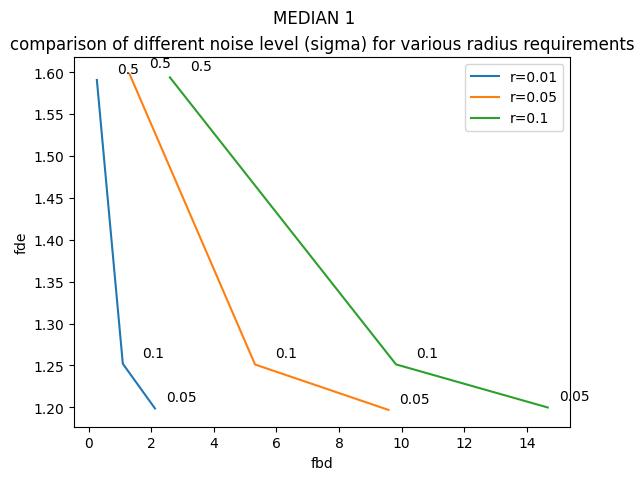

In [139]:
fig, ax = plt.subplots()

[ax.plot(df_med1_mean[df_med1_mean["r"] == r]["fbd"], df_med1_mean[df_med1_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
plt.suptitle("MEDIAN 1")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med1_mean[df_med1_mean["r"] == r]["fbd"],df_med1_mean[df_med1_mean["r"] == r]["fde"])):

        label = str(df_med1_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

## With median 2

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 50$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

In [140]:
df_r_001_s_005 = pd.read_csv("data/med2/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/med2/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_05 = pd.read_csv("data/med2/temp_sig0.5_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/med2/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/med2/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_05 = pd.read_csv("data/med2/temp_sig0.5_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/med2/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/med2/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_05 = pd.read_csv("data/med2/temp_sig0.5_r0.1.txt", sep="\t")

df_all_med2 = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_05, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_05,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_05), ignore_index=True)

In [141]:
df_med2_mean = df_all_med2.groupby(["r", "sigma"], as_index=False).mean()

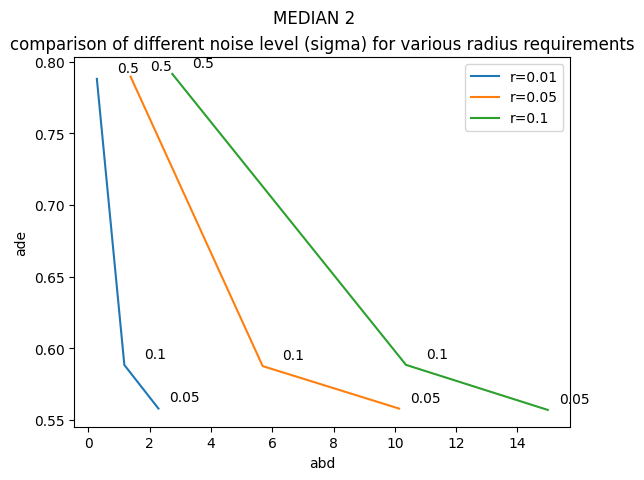

In [142]:
fig, ax = plt.subplots()

[ax.plot(df_med2_mean[df_med2_mean["r"] == r]["abd"], df_med2_mean[df_med2_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("MEDIAN 2")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med2_mean[df_med2_mean["r"] == r]["abd"],df_med2_mean[df_med2_mean["r"] == r]["ade"])):

        label = str(df_med2_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is very similar to the previous.

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The median of type 2 was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the ade gets worse. <br>
Also, for values of $\sigma \lessapprox 10*r$, we see that the box dimensions gets really large.

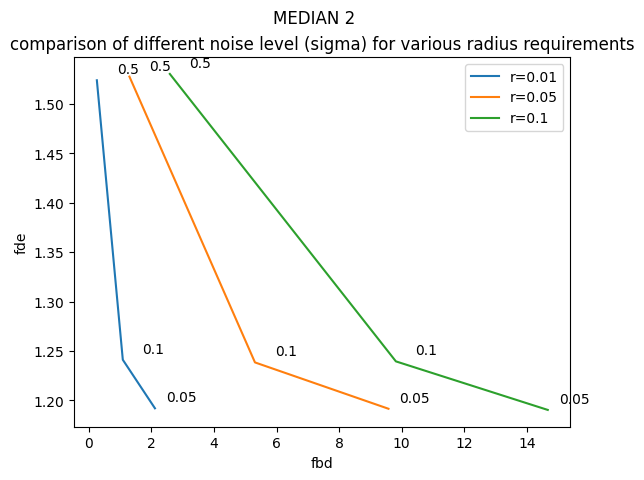

In [143]:
fig, ax = plt.subplots()

[ax.plot(df_med2_mean[df_med2_mean["r"] == r]["fbd"], df_med2_mean[df_med2_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
plt.suptitle("MEDIAN 2")
plt.legend()

for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_med2_mean[df_med2_mean["r"] == r]["fbd"],df_med2_mean[df_med2_mean["r"] == r]["fde"])):

        label = str(df_med2_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(30,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

# With diffusion

Data were generate over the whole test dataset (private with the ground truth here). In total, I generated 9 data while changing the hyperparameters. All combinaison of $r = 1, 5, 10$ cm and $\sigma = 5, 10, 23$ cm were used. Then, the metrics are averaged over all the 3146 scenes.

I couldn't use $\sigma = 0.5$ m because of the way the diffusion scheduler is designed. $\sigma = 0.23$ coresponds to the maximal timestep 100. To allow for higher noise level, one should retrain the model with another scheduler (probably by setting beta_T to 1 instead of 0.05).

Here is an example of the difusion of a noisy trajectory.

<p align="center">
    <img src="../../figures_readme/denoising_scene_20.gif"  width="500">
</p>

Note that here the diffusion denoising is done step by step. To generate the data, I used "one-shot" diffusion, with only one big denoising step applied. The authors of [5] argue that this gave better results, but it looks very similar. Anyway, I found cool to see this denoising in action with this .gif.



[5] Carlini, N., Tramer, F., & Kolter, J. Z. (2022). (Certified!!) Adversarial Robustness for Free!. arXiv preprint arXiv:2206.10550.

In [144]:
df_r_001_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/diff/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/diff/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/diff/temp_sig0.1_r0.1.txt", sep="\t")
#df_r_01_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.1.txt", sep="\t")

df_all_diff = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_023, 
                    df_r_005_s_005, df_r_005_s_01, df_r_005_s_023,
                    df_r_01_s_005, df_r_01_s_01,                ), ignore_index=True) #missing one

In [145]:
df_diff_mean = df_all_diff.groupby(["r", "sigma"], as_index=False).mean()
df_diff_mean

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.563574,1.177173,2.360178,2.192059
1,0.01,0.10,710.017165,0.564554,1.172293,1.220236,1.137002
2,0.01,0.23,710.017165,1.075127,1.636681,0.617465,0.584501
3,0.05,0.05,710.017165,0.563977,1.179823,10.474385,9.910253
4,0.05,0.10,710.017165,0.564890,1.173558,5.907205,5.529926
5,0.05,0.23,710.017165,1.078609,1.642803,3.066314,2.903964
6,0.10,0.05,710.017165,0.562715,1.176861,15.449735,15.127097
7,0.10,0.10,710.017165,0.565232,1.174495,10.765717,10.214157


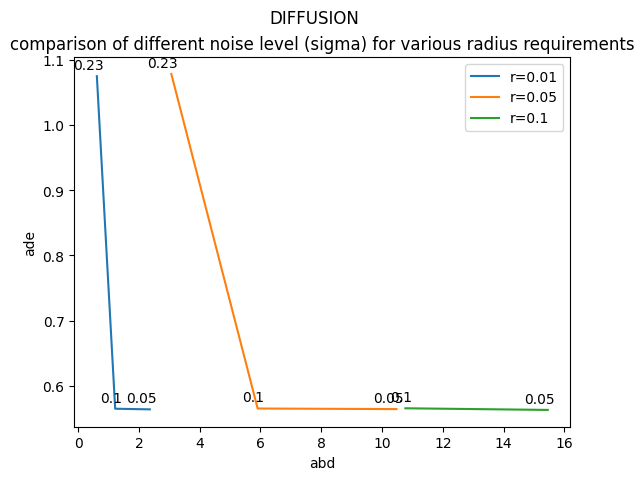

In [146]:
fig, ax = plt.subplots()

[ax.plot(df_diff_mean[df_diff_mean["r"] == r]["abd"], df_diff_mean[df_diff_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
plt.suptitle("DIFFUSION")
plt.legend()


for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_diff_mean[df_diff_mean["r"] == r]["abd"],df_diff_mean[df_diff_mean["r"] == r]["ade"])):

        label = str(df_diff_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(5,5), # distance from text to points (x,y)
                    ha='right')

This time, we see that the plot is a bit different than the previous.

For each different maximal perturbation radius $r$ (different line color), 3 values of noise standard deviation $\sigma$ were tested. The noise level is specified above the point. On this plot, the ade and abd are reported on the axis for each combinaison of parameters. The median of type 2 was use to approximate the expectation.

We see that for a bigger noise level, the adb is better, but the does not ade gets worse this time. <br>
What we see is that for $\sigma=0.23$m, which coresponds to $t^* = 100$ the ade gets really worse.

As it could be interesting to have more datapoints, another plot of this kind is generated later, with more datapoints.

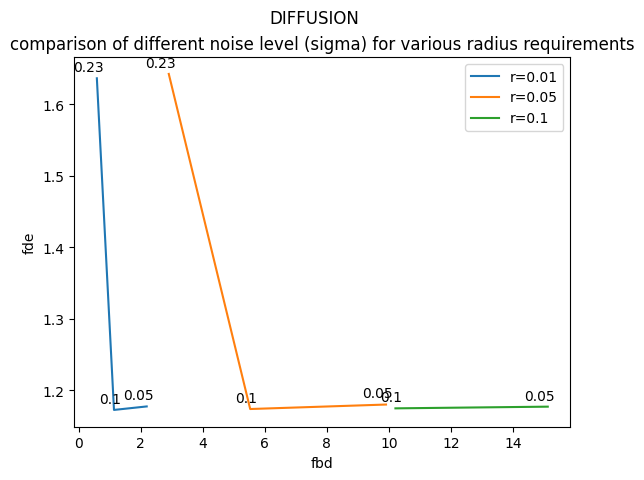

In [147]:
fig, ax = plt.subplots()

[ax.plot(df_diff_mean[df_diff_mean["r"] == r]["fbd"], df_diff_mean[df_diff_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
plt.suptitle("DIFFUSION")
plt.legend()


for r in [0.01, 0.05, 0.10]:
    for i, (x,y) in enumerate(zip(df_diff_mean[df_diff_mean["r"] == r]["fbd"],df_diff_mean[df_diff_mean["r"] == r]["fde"])):

        label = str(df_diff_mean.iloc[i]["sigma"])

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(5,5), # distance from text to points (x,y)
                    ha='right')

This plot is alike the other, but showcasing the fde and fbd on the axis.

# With diffusion - WRONG

In [148]:
df_r_001_s_005 = pd.read_csv("data/diff_wrong/temp_sig0.05_r0.01.txt", sep="\t")
df_r_001_s_01 = pd.read_csv("data/diff_wrong/temp_sig0.1_r0.01.txt", sep="\t")
df_r_001_s_023 = pd.read_csv("data/diff_wrong/temp_sig0.23_r0.01.txt", sep="\t")

df_r_005_s_005 = pd.read_csv("data/diff_wrong/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_01_diff = pd.read_csv("data/diff_wrong/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/diff_wrong/temp_sig0.23_r0.05.txt", sep="\t")

df_r_01_s_005 = pd.read_csv("data/diff_wrong/temp_sig0.05_r0.1.txt", sep="\t")
df_r_01_s_01 = pd.read_csv("data/diff_wrong/temp_sig0.1_r0.1.txt", sep="\t")
df_r_01_s_023 = pd.read_csv("data/diff_wrong/temp_sig0.23_r0.1.txt", sep="\t")

df_all_diff_w = pd.concat((df_r_001_s_005, df_r_001_s_01, df_r_001_s_023, 
                    df_r_005_s_005, df_r_005_s_01_diff, df_r_005_s_023,
                    df_r_01_s_005, df_r_01_s_01, df_r_01_s_023), ignore_index=True)

In [149]:
df_diff_mean_w = df_all_diff_w.groupby(["r", "sigma"], as_index=False).mean()
df_diff_mean_w

,r,sigma,scene_id,ade,fde,abd,fbd
0,0.01,0.05,710.017165,0.566224,1.177270,2.782684,2.649205
1,0.01,0.10,710.017165,0.567810,1.170591,1.523920,1.459346
2,0.01,0.23,710.017165,1.189329,1.880357,0.930050,0.898776
3,0.05,0.05,710.017165,0.567843,1.180484,12.265432,11.826237
4,0.05,0.10,710.017165,0.567784,1.173106,7.367552,7.077401
5,0.05,0.23,710.017165,1.189894,1.882025,4.616671,4.463344
6,0.10,0.05,710.017165,0.567157,1.179767,17.845646,17.608512
7,0.10,0.10,710.017165,0.567495,1.170812,13.346343,12.929021
8,0.10,0.23,710.017165,1.192158,1.885334,9.038801,8.750409


In [150]:
# fig, ax = plt.subplots()

# [ax.plot(df_diff_mean_w[df_diff_mean_w["r"] == r]["abd"], df_diff_mean_w[df_diff_mean_w["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
# ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
# plt.suptitle("DIFFUSION")
# plt.legend()

# [ax.plot(df_diff_mean[df_diff_mean["r"] == r]["abd"], df_diff_mean[df_diff_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01]]


# for r in [0.01, 0.05, 0.10]:
#     for i, (x,y) in enumerate(zip(df_diff_mean_w[df_diff_mean_w["r"] == r]["abd"],df_diff_mean_w[df_diff_mean_w["r"] == r]["ade"])):

#         label = str(df_diff_mean_w.iloc[i]["sigma"])

#         plt.annotate(label, # this is the text
#                     (x,y), # these are the coordinates to position the label
#                     textcoords="offset points", # how to position the text
#                     xytext=(5,5), # distance from text to points (x,y)
#                     ha='right')

In [151]:
# fig, ax = plt.subplots()

# [ax.plot(df_diff_mean[df_diff_mean["r"] == r]["fbd"], df_diff_mean[df_diff_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
# ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
# plt.suptitle("DIFFUSION")
# plt.legend()


# for r in [0.01, 0.05, 0.10]:
#     for i, (x,y) in enumerate(zip(df_diff_mean[df_diff_mean["r"] == r]["fbd"],df_diff_mean[df_diff_mean["r"] == r]["fde"])):

#         label = str(df_diff_mean.iloc[i]["sigma"])

#         plt.annotate(label, # this is the text
#                     (x,y), # these are the coordinates to position the label
#                     textcoords="offset points", # how to position the text
#                     xytext=(5,5), # distance from text to points (x,y)
#                     ha='right')

In [152]:
# fig, ax = plt.subplots()

# [ax.plot(df_diff_mean_w[df_diff_mean_w["r"] == r]["abd"], df_diff_mean_w[df_diff_mean_w["r"] == r]["ade"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
# ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="abd", ylabel="ade")
# plt.suptitle("DIFFUSION")
# plt.legend()

# [ax.plot(df_diff_mean[df_diff_mean["r"] == r]["abd"], df_diff_mean[df_diff_mean["r"] == r]["ade"], label = f"r={r}") for r in [0.01]]


# for r in [0.01, 0.05, 0.10]:
#     for i, (x,y) in enumerate(zip(df_diff_mean_w[df_diff_mean_w["r"] == r]["abd"],df_diff_mean_w[df_diff_mean_w["r"] == r]["ade"])):

#         label = str(df_diff_mean_w.iloc[i]["sigma"])

#         plt.annotate(label, # this is the text
#                     (x,y), # these are the coordinates to position the label
#                     textcoords="offset points", # how to position the text
#                     xytext=(5,5), # distance from text to points (x,y)
#                     ha='right')

In [153]:
# fig, ax = plt.subplots()

# [ax.plot(df_diff_mean_w[df_diff_mean_w["r"] == r]["fbd"], df_diff_mean_w[df_diff_mean_w["r"] == r]["fde"], label = f"r={r}") for r in [0.01, 0.05, 0.10]]
# ax.set(title="comparison of different noise level (sigma) for various radius requirements", xlabel="fbd", ylabel="fde")
# plt.suptitle("DIFFUSION")
# plt.legend()

# [ax.plot(df_diff_mean[df_diff_mean["r"] == r]["fbd"], df_diff_mean[df_diff_mean["r"] == r]["fde"], label = f"r={r}") for r in [0.01]]

# for r in [0.01, 0.05, 0.10]:
#     for i, (x,y) in enumerate(zip(df_diff_mean_w[df_diff_mean_w["r"] == r]["fbd"],df_diff_mean_w[df_diff_mean_w["r"] == r]["fde"])):

#         label = str(df_diff_mean_w.iloc[i]["sigma"])

#         plt.annotate(label, # this is the text
#                     (x,y), # these are the coordinates to position the label
#                     textcoords="offset points", # how to position the text
#                     xytext=(5,5), # distance from text to points (x,y)
#                     ha='right')

# Comparison mean vs med1 vs med2 vs diffusion for fix r

recall : 

mean : take the mean for all agent, all timestep, all dimension of the N (=100) noisy predictions generated -> the resulting trajectory is thus not necessarly one generated by the noisy predictions.

median1 : among the N (=100) noisy predictions generated, take the one with the smallest distance with respect to all the other.

median2 : take the median for all agent, all timestep, all dimension of the N (=100) noisy samples generated. -> the resulting trajectory is thus not necessarly one generated by the noisy predictions. 

diffusion : apply a diffusion denoiser model (trained to generate trajs data) after the noising step. Then, Expectancy is computed with the mean

First, lets look at the prediction on a custom exmaple : 2 agents facing each other. We expect the median1 to be better, as it is the only prediction that outputs a "real" trajectory. 

<p align="center">
    <img src="../../figures_readme/all_noisy_trajs_rand_mean.png"  width="490">
    <img src="../../figures_readme/all_noisy_trajs_rand_diff.png"  width="490">
    <img src="../../figures_readme/all_noisy_trajs_rand_med.png"  width="490">
    <img src="../../figures_readme/all_noisy_trajs_rand_med2.png"  width="490">
</p>

Surprisingly, only diffusion has a "potential" colision. Probably because its predictions are more grouped, the means were closer to each other.

Plots with $\sigma = 15$ cm and r = 5cm (not visible on those plots), on custom scene.

### r = 1cm

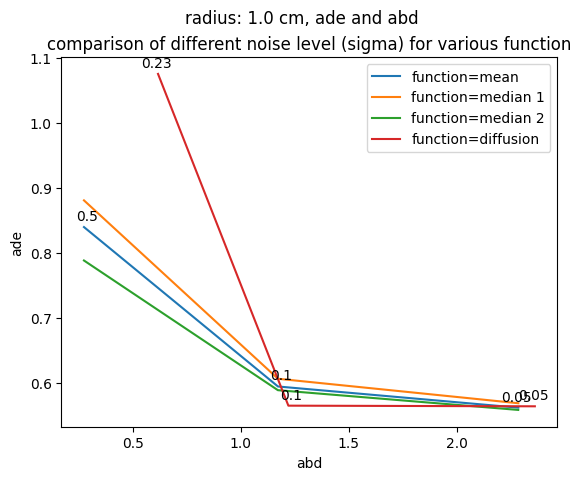

In [154]:
fig, ax = plt.subplots()
r = 0.01 # 1 cm
func_name = ["mean", "median 1", "median 2", "diffusion"]
[ax.plot(df[df["r"] == r]["abd"], df[df["r"] == r]["ade"], label = f"function={func_name[i]}") for i, df in enumerate(
        [df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="abd", ylabel="ade")
plt.suptitle(f"radius: {r*100} cm, ade and abd")
for df in (df_mean_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["abd"],df[df["r"] == r]["ade"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

This plot is very interesting. <br>
We see that denoising the signal with the diffusion process really helps to keep the ade low, while reducing the adb. This is true as long as $\sigma$ is not too large.

At the end of this notebook, a plot with more data shows this effect even better.

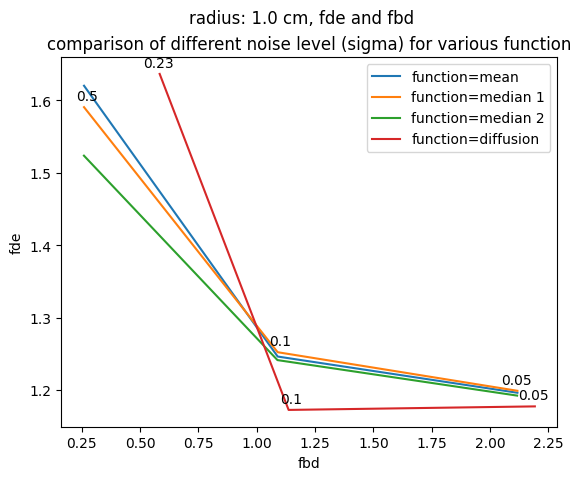

In [155]:
fig, ax = plt.subplots()
r = 0.01 # 1 cm
func_name = ["mean", "median 1", "median 2", "diffusion"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate(
        [df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med1_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

This effect is even more clear when looking at the fde.

### r = 5cm

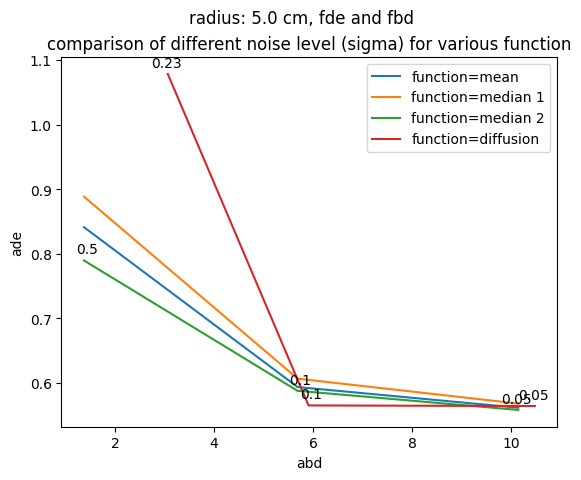

In [164]:
fig, ax = plt.subplots()
r = 0.05 # 5 cm
func_name = ["mean", "median 1", "median 2", "diffusion"]
[ax.plot(df[df["r"] == r]["abd"], df[df["r"] == r]["ade"], label = f"function={func_name[i]}") for i, df in enumerate(
        [df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="abd", ylabel="ade")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["abd"],df[df["r"] == r]["ade"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

This plot looks similar to the other with r = 1cm, but the abd scale changes.

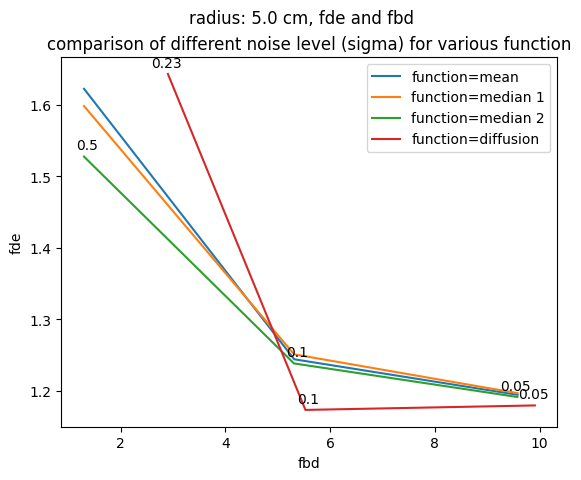

In [165]:
fig, ax = plt.subplots()
r = 0.05 # 5 cm
func_name = ["mean", "median 1", "median 2", "diffusion"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate(
        [df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

### r = 10cm

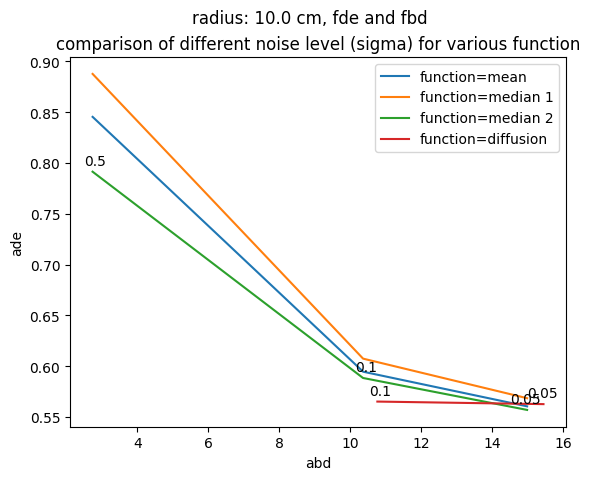

In [168]:
fig, ax = plt.subplots()
r = 0.1 # 10 cm
func_name = ["mean", "median 1", "median 2", "diffusion"]
[ax.plot(df[df["r"] == r]["abd"], df[df["r"] == r]["ade"], label = f"function={func_name[i]}") for i, df in enumerate(
        [df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="abd", ylabel="ade")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["abd"],df[df["r"] == r]["ade"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

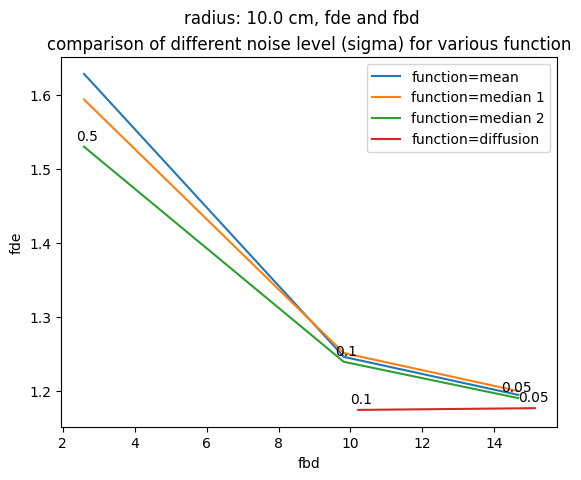

In [166]:
fig, ax = plt.subplots()
r = 0.1 # 10 cm
func_name = ["mean", "median 1", "median 2", "diffusion"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate(
        [df_mean_mean, df_med1_mean, df_med2_mean, df_diff_mean])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_med2_mean, df_diff_mean):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

# Focus diff vs mean r= 5cm

In this section, I generated more data to better see the impact of diffusion.

In [169]:
#diff
df_r_005_s_005 = pd.read_csv("data/diff/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_0075 = pd.read_csv("data/diff/temp_sig0.075_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/diff/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_0125 = pd.read_csv("data/diff/temp_sig0.125_r0.05.txt", sep="\t")
df_r_005_s_015 = pd.read_csv("data/diff/temp_sig0.15_r0.05.txt", sep="\t")
df_r_005_s_0175 = pd.read_csv("data/diff/temp_sig0.175_r0.05.txt", sep="\t")
df_r_005_s_02 = pd.read_csv("data/diff/temp_sig0.2_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/diff/temp_sig0.23_r0.05.txt", sep="\t")

df_all_diff_more = pd.concat((df_r_005_s_005, df_r_005_s_0075, df_r_005_s_01,
                              df_r_005_s_0125,df_r_005_s_015,df_r_005_s_0175,
                              df_r_005_s_02, df_r_005_s_023), ignore_index=True)

df_diff_mean_more = df_all_diff_more.groupby(["r", "sigma"], as_index=False).mean()

In [159]:
df_all_diff_more.shape

(25168, 7)

In [160]:
#mean
df_r_005_s_005 = pd.read_csv("data/mean/temp_sig0.05_r0.05.txt", sep="\t")
df_r_005_s_0075 = pd.read_csv("data/mean/temp_sig0.075_r0.05.txt", sep="\t")
df_r_005_s_01 = pd.read_csv("data/mean/temp_sig0.1_r0.05.txt", sep="\t")
df_r_005_s_0125 = pd.read_csv("data/mean/temp_sig0.125_r0.05.txt", sep="\t")
df_r_005_s_015 = pd.read_csv("data/mean/temp_sig0.15_r0.05.txt", sep="\t")
df_r_005_s_0175 = pd.read_csv("data/mean/temp_sig0.175_r0.05.txt", sep="\t")
df_r_005_s_02 = pd.read_csv("data/mean/temp_sig0.2_r0.05.txt", sep="\t")
df_r_005_s_023 = pd.read_csv("data/mean/temp_sig0.23_r0.05.txt", sep="\t")


df_all_mean_more = pd.concat((df_r_005_s_005, df_r_005_s_0075, df_r_005_s_01,
                              df_r_005_s_0125,df_r_005_s_015,df_r_005_s_0175,
                              df_r_005_s_02, df_r_005_s_023), ignore_index=True)

df_mean_mean_more = df_all_mean_more.groupby(["r", "sigma"], as_index=False).mean()


In [161]:
df_all_mean_more.shape

(25168, 7)

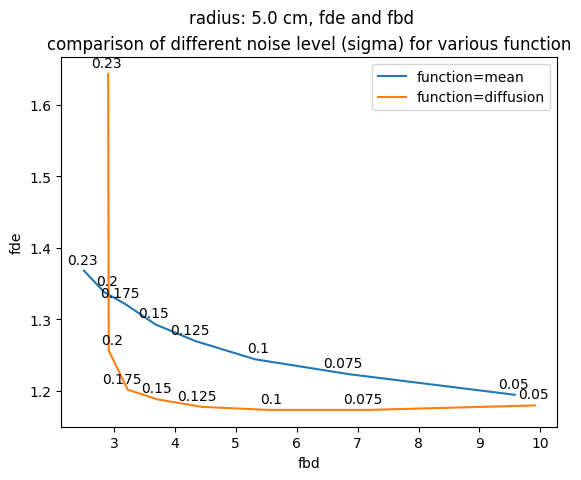

In [162]:
fig, ax = plt.subplots()
r = 0.05 # 1 cm
func_name = ["mean","diffusion"]
[ax.plot(df[df["r"] == r]["fbd"], df[df["r"] == r]["fde"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean_more, df_diff_mean_more])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="fbd", ylabel="fde")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_mean_mean_more, df_diff_mean_more):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["fbd"],df[df["r"] == r]["fde"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

This plot clearly shows the power of diffusion denoising. It allows to increase $\sigma$ to reduce the fbd, without having an increase of fde as a tradeoff. 

With a retraining of the model with beta_T = 1 (instead of 0.05), I think that this suden jumps for $\sigma = 0.23$ (which corespond to $t^*$ = 100), will appear much later. This could allow for even higher $\sigma$ to decrease the fdb, wihout looding any fde points.

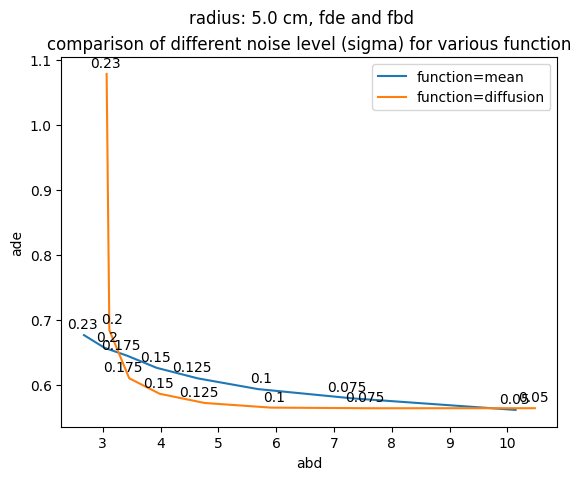

In [170]:
fig, ax = plt.subplots()
r = 0.05 # 1 cm
func_name = ["mean","diffusion"]
[ax.plot(df[df["r"] == r]["abd"], df[df["r"] == r]["ade"], label = f"function={func_name[i]}") for i, df in enumerate([df_mean_mean_more, df_diff_mean_more])]
ax.set(title="comparison of different noise level (sigma) for various function", xlabel="abd", ylabel="ade")
plt.suptitle(f"radius: {r*100} cm, fde and fbd")
for df in (df_mean_mean_more, df_diff_mean_more):
        for i, (x,y) in enumerate(zip(df[df["r"] == r]["abd"],df[df["r"] == r]["ade"])):

                label = str(df.iloc[i]["sigma"])

                plt.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(10,5), # distance from text to points (x,y)
                        ha='right')

plt.legend()

For the averaged metrics, the effect is less big, but still present.

### Example showing the difference

On the example below, we show the difference between the mean prediction and the mean-diffusion-denoised prediction. We can see that the denoising step groups the noisy observation together, which leads the prediction (blue) to be more like the ground truth (purple).<br>
On top of that, we can see how the 100 noisy predictions can differ, depending on the noise, and how, on average, the prediction is pretty good.

<p align="center">
<img src="../../figures_readme/all_noisy_trajs_mean_gt.png" width="550" /> 
  <img src="../../figures_readme/all_noisy_trajs_diffusion_gt.png" width="550" />
  
</p>

Plots with $\sigma = 15$ cm and r = 5cm (not visible on those plots), on scene 222, with ground truth.